In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from lifelines import KaplanMeierFitter
import requests
import math
from itertools import combinations
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import seaborn as sns

### Settings (Edit Each Run)

In [2]:
# Set this to the project config
config = "../global_config_bash.rc"

geneToStudy = 'MYCN'
cancerTypeToStudy = 'Neuroblastoma'
# cancerType or cancerTypeDetailed or oncotreeLevel2
analysis_type = 'oncotreeLevel2'

# Use facets called amp (true/false), use false if you do not have the file (external to the pipeline)
use_facets_copy_number = False

# Use facets amplification
use_facets_amp = True

# matplotlib colors. For ecDNA - amp -, ecDNA - amp +, and ecDNA +. First one is also a general color, we recommend keeping defaults
colors = ["steelblue", "navajowhite", "coral"]

# Fill path if using external facets data
if use_facets_copy_number :
    facets_cn = pd.read_csv("../mycn_facets_merged.tsv", sep = '\t', index_col = False)

### Get files from config

In [3]:
## open config file ##
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [4]:
## Set up dataframes ##

# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged_ecDNA_results_filtered_p_ecDNA_impactGene_annotated.tsv', sep = '\t')
# Merged FACETS cbioportal file
manifest = pd.read_csv(paths['mergedOutputDirectory'] + '/facets_cbioportal_merged_full.tsv', sep = '\t')
if use_facets_amp :
    facets = pd.read_csv(paths['mergedOutputDirectory'] + '/merged_facets_filtered_p_ecDNA_impactGene_annotated.tsv', sep = '\t')

### Clean Up and Prepare Dataframes

In [5]:
## Set up oncotree codes via Oncotree API ##

url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {'Accept': 'application/json'}

response = requests.get(url, headers=headers)

# Turn tree into a dict
def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

# Dict of oncotree code to name
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


In [6]:
## Merge echo and manifest ##

echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'gene', 'ecDNA_prob', 'ecDNA_status']]

manifest['sampleId'] = manifest['ID']
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'osMonths', 'oncotreeCode']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')
echo['oncotreeLevel2'] = ""

for i, row in echo.iterrows() :
    for key in oncotree_dict :
        if row['oncotreeCode'] in oncotree_dict[key] :
            echo.loc[i, 'oncotreeLevel2'] = key

# Trim dataframe
echo_ctype = echo[echo[analysis_type] == cancerTypeToStudy]

In [7]:
## Add facets amp information if using facets amp ##

if use_facets_amp : 
    facets['patientId'] = facets['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])

    # amplification status
    facets_gene_amps = {key: "INDETERMINATE" for key in facets['patientId'].unique()}
    
    for i, row in facets.iterrows() :
        if row['gene'] == geneToStudy :
            facets_gene_amps[row['patientId']] = row['cn_state']

    echo_ctype['facets_amp'] = 'INDETERMINATE'

    for i, row in echo_ctype.iterrows() :
        try :
            echo_ctype.loc[i, 'facets_amp'] = facets_gene_amps[row['patientId']]
        except :
            _ = 5

/tmp/ipykernel_16889/1161497475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  echo_ctype['facets_amp'] = 'INDETERMINATE'


In [8]:
## Create a dataframe just for the one gene in the one cancer type ##

specific_gene_ctype = pd.DataFrame({'patientId': echo_ctype['patientId'].unique()})
specific_gene_ctype['ecDNA_status'] = False
specific_gene_ctype['osStatus'] = ""
specific_gene_ctype['osMonths'] = np.nan
specific_gene_ctype['amp'] = False
specific_gene_ctype['cn_echo'] = 2

# connect patient IDs to indexes
gene_dict = {}
for i, row in specific_gene_ctype.iterrows() :
    gene_dict[row['patientId']] = i

# Fill in dataframe
for i, row in echo_ctype.iterrows() :
    specific_gene_ctype.loc[gene_dict[row['patientId']], 'osStatus'] = row['osStatus']
    specific_gene_ctype.loc[gene_dict[row['patientId']], 'osMonths'] = row['osMonths']
    if row['gene'] == geneToStudy :
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'ecDNA_status'] = (row['ecDNA_status'] == 'ecDNA')
        if use_facets_amp :
            if not isinstance(row['facets_amp'], float) :
                if ('AMP' in row['facets_amp']) or ('GAIN' in row['facets_amp']) :
                    amp_status = True
                else :
                    amp_status = False
            specific_gene_ctype.loc[gene_dict[row['patientId']], 'amp'] = amp_status
        else :
            specific_gene_ctype.loc[gene_dict[row['patientId']], 'amp'] = True

In [9]:
## Create a combined column that describes ecDNA and amplification status ##

specific_gene_ctype['combined_status'] = ''
for i, row in specific_gene_ctype.iterrows() :
    if row['ecDNA_status'] and row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "ecDNA & Called"
    elif row['ecDNA_status'] and not row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "ecDNA & Not Called"
    elif not row['ecDNA_status'] and row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "no ecDNA & Called"
    else :
        specific_gene_ctype.loc[i, 'combined_status'] = "no ecDNA & Not Called"


### KM and Cox Models

In [10]:
## Get timeline data from CDSI ##

# follow up timeline data (from CDSI github)
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_follow_up.txt', sep = '\t')
diagnosis = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_diagnosis.txt', sep = '\t')

# Times of diagnosis
diagnosis_dict = {}
# Times of last contact
last_contact_dict = {}

specific_gene_ctype['time'] = np.nan

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

for i, row in diagnosis.iterrows() :
    if row['PATIENT_ID'] in diagnosis_dict :
        diagnosis_dict[row['PATIENT_ID']] = min(diagnosis_dict[row['PATIENT_ID']], row['START_DATE'])
    else :
        diagnosis_dict[row['PATIENT_ID']] = row['START_DATE']

for i, row in specific_gene_ctype.iterrows() :
    p_id = row['patientId']
    if p_id in last_contact_dict and p_id in diagnosis_dict :
        specific_gene_ctype.loc[i, 'time'] = last_contact_dict[p_id] - diagnosis_dict[p_id]

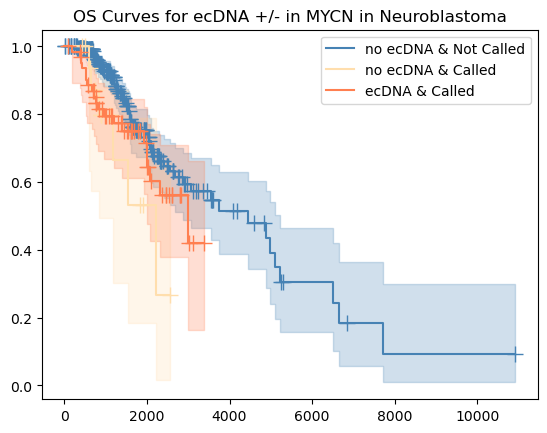

In [11]:
## Plot OS curve ##

specific_gene_ctype_nona = specific_gene_ctype.dropna(subset = ['combined_status', 'time', 'osStatus'])

kmf = KaplanMeierFitter()
for i, status in enumerate(['no ecDNA & Not Called', 'no ecDNA & Called', 'ecDNA & Called']) :

    subset = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == status]
    kmf.fit(subset['time'], event_observed=(subset['osStatus'] == 'DECEASED'))

    kmf.plot(show_censors=True, ci_show=True, label=f'{status}', color = colors[i])

# # Add labels and legend
plt.title(f'OS Curves for ecDNA +/- in {geneToStudy} in {cancerTypeToStudy}')
plt.xlabel("")
plt.legend()

In [12]:
## Get pairwise p-values ##

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = ['no ecDNA & Not Called', 'no ecDNA & Called', 'ecDNA & Called']
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == group1]
    group2_data = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['time'], event_observed=(group1_data['osStatus'] == 'DECEASED'))
    kmf2.fit(group2_data['time'], event_observed=(group2_data['osStatus'] == 'DECEASED'))
    
    # Perform log-rank test
    result = logrank_test(group1_data['time'], group2_data['time'], event_observed_A=(group1_data['osStatus'] == 'DECEASED'), event_observed_B=(group2_data['osStatus'] == 'DECEASED'))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,no ecDNA & Called,ecDNA & Called
no ecDNA & Not Called,0.015414,0.085984
no ecDNA & Called,,0.381038


In [13]:
## Cox model for ecDNA status and amp ##

gene_cox = specific_gene_ctype.dropna(subset = ['time', 'osStatus', 'ecDNA_status', 'amp'])
gene_cox['eventOccurred'] = np.nan
for i, row in gene_cox.iterrows() :
    gene_cox.loc[i, 'eventOccurred'] = int(row['osStatus'] == 'DECEASED')

cox = CoxPHFitter()
covariates = ['time', 'eventOccurred', 'amp', 'ecDNA_status']
cox.fit(gene_cox[covariates], duration_col = 'time', event_col = 'eventOccurred')
cox.print_summary()


/tmp/ipykernel_16889/443326052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_cox['eventOccurred'] = np.nan


<lifelines.CoxPHFitter: fitted with 348 total observations, 260 right-censored observations>
             duration col = 'time'
                event col = 'eventOccurred'
      baseline estimation = breslow
   number of observations = 348
number of events observed = 88
   partial log-likelihood = -411.50
         time fit was run = 2025-01-07 17:39:47 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
amp            0.97       2.63       0.43             0.12             1.82                 1.12                 6.16
ecDNA_status  -0.52       0.60       0.47            -1.43             0.40                 0.24                 1.49

               cmp to     z    p   -log2(p)
covariate                                  
amp              0.00  2.23 0.03       5.27
ecDNA_status     0.00 -1.10 0.27       1.89
---
Concordance = 0.58
Partial AIC = 827.01
log-likelihood ratio test = 5.92 on 2 df
-log2(p) of ll-ratio test = 4.27

### FACETS Copy Number Covariate (EXPERIMENTAL)

In [14]:
## Create dataframe based on cox results ##

if use_facets_copy_number :
    
    # dataframe to hold numbers
    specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])
    
    gene_cox = specific_gene_ctype.dropna(subset = ['time', 'osStatus', 'ecDNA_status', 'amp'])
    gene_cox['eventOccurred'] = np.nan
    for i, row in gene_cox.iterrows() :
        gene_cox.loc[i, 'eventOccurred'] = int(row['osStatus'] == 'DECEASED')

    # Get facets copy numbers
    gene_cox['cn_facets'] = np.nan
    facets_cn_dict = {}
    for i, row in facets_cn.iterrows() :
        pId = row['sample_id'].split('-')[0] + '-' + row['sample_id'].split('-')[1]
        facets_cn_dict[pId] = row['tcn']
    for i, row in gene_cox.iterrows() :
        if row['patientId'] in facets_cn_dict :
            gene_cox.loc[i, 'cn_facets'] = facets_cn_dict[row['patientId']]
    gene_cox = gene_cox.dropna(subset = ['cn_facets'])
        
    def get_cox_results (covariates, name) :
        cox = CoxPHFitter()
        cox.fit(gene_cox[covariates], duration_col = 'time', event_col = 'eventOccurred')
        new_row = {
            'atype' : name,
            'p_value' : cox.summary['p']['ecDNA_status'],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA_status'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA_status'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA_status']
        }
        new_df = pd.DataFrame([new_row])
        return new_df

    # Just ecDNA +/-
    ecDNA_only = get_cox_results(['time', 'eventOccurred', 'ecDNA_status'], 'ecDNA Status')
    specific_cox_df = pd.concat([specific_cox_df, ecDNA_only], ignore_index = True)
    
    # ecDNA plus echo amplification status
    ecDNA_amp = get_cox_results(['time', 'eventOccurred', 'amp', 'ecDNA_status'], 'ecDNA Status + ECHO Amp')
    specific_cox_df = pd.concat([specific_cox_df, ecDNA_amp], ignore_index = True)

    ecDNA_cn = get_cox_results(['time', 'eventOccurred', 'cn_facets', 'ecDNA_status'], 'ecDNA Status + FACETS CN')
    specific_cox_df = pd.concat([specific_cox_df, ecDNA_cn], ignore_index = True)

In [15]:
## P-value bar plot 

if use_facets_copy_number :
    
    specific_cox_df = specific_cox_df.sort_values(by='p_value')
    plt.figure(figsize=(6, 6))
    bars = sns.barplot(x='atype', y='p_value', data=specific_cox_df, palette = colors)
    plt.xlabel('Variables')
    plt.ylabel('p-values')
    plt.title('Sorted DataFrame Bar Plot')
    bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
    plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
    plt.title("ecDNA Status P-Values for Cox Hazard Ratios")
    plt.show()

In [16]:
## Hazard ratios for cox models ##

if use_facets_copy_number :

    non_zero = specific_cox_df[specific_cox_df['lower'] != 0]
    num_rows = non_zero.shape[0]
    
    plt.figure(figsize=(6, 8))
    positions = np.arange(num_rows)
    plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
                 fmt='o', markersize=8, capsize=5, capthick=2, color = colors[0])
    
    plt.xlabel('Variables')
    plt.xticks(positions, non_zero['atype'],rotation=45, ha='right')
    
    
    # Add labels and title
    plt.ylabel('Hazard Ratio')
    plt.title('Hazard Ratios (95% Confindence)')
    plt.axhline(y=1, color=colors[2], linestyle='--', linewidth=2)
    
    plt.grid(True, axis='y')  # Add grid lines for better visualization
    plt.tight_layout()
    plt.show()

### Facets Analysis

In [17]:
## Set up copy number and segment length ##

if use_facets_amp :
    # create dictionaries for segment lengths and which samples are amplified
    segment_lengths = {}
    facets_amps = {}
    for i, row in facets.iterrows() :
        if isinstance(row['cn_state'], str) :
            segment_lengths[row['sample_id']] = row['seg_length']
            if "AMP" in row['cn_state'] :
                facets_amps[row['sample_id']] = True

    # Make a dataframe to analyze
    facets_lengths_df = facets[['sample_id', 'seg_length', 'tcn']]
    
    # These are the samples to use
    ctype_sampleIds = {}
    # These are for labeling ecDNA pos and neg (to get rid of na ones)
    ecDNA_pos = {}
    ecDNA_neg = {}
    for i, row in echo_ctype.iterrows() :
        if row[analysis_type] == cancerTypeToStudy :
            ctype_sampleIds[row['tumorSampleId']] = True
            if row['tumorSampleId'] in facets_amps :
                if row['ecDNA_status'] == 'ecDNA' :
                    ecDNA_pos[row['tumorSampleId']] = True
                if row['ecDNA_status'] == 'non-ecDNA' :
                    ecDNA_neg[row['tumorSampleId']] = True
    facets_lengths_df = facets_lengths_df[facets_lengths_df['sample_id'].isin(ctype_sampleIds)]
    
    # Label the ones that are not called na
    facets_lengths_df['ecDNA'] = np.nan
    
    for i, row in facets_lengths_df.iterrows() :
        if row['sample_id'] in ecDNA_pos :
            facets_lengths_df.loc[i, 'ecDNA'] = True
        if row['sample_id'] in ecDNA_neg :
            facets_lengths_df.loc[i, 'ecDNA'] = False

/tmp/ipykernel_16889/418342960.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  facets_lengths_df.loc[i, 'ecDNA'] = True


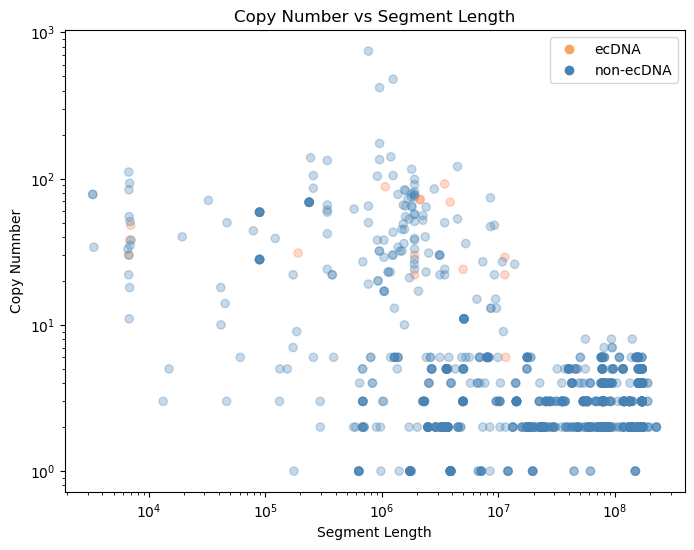

In [18]:
if use_facets_amp :

    facets_lengths_df_nona = facets_lengths_df.dropna()
    
    facets_amp = facets_lengths_df_nona
    
    # Define colors for each category
    color_map = {True: colors[2], False: colors[0]}
    
    # Create a list of colors based on the 'ecDNA' column
    plot_colors = facets_amp['ecDNA'].map(color_map)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(facets_amp['seg_length'], facets_amp['tcn'], c=plot_colors, label=facets_amp['ecDNA'], alpha = 0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Copy Numnber')
    plt.xlabel('Segment Length')
    plt.title("Copy Number vs Segment Length")
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = ['sandybrown', 'steelblue']
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

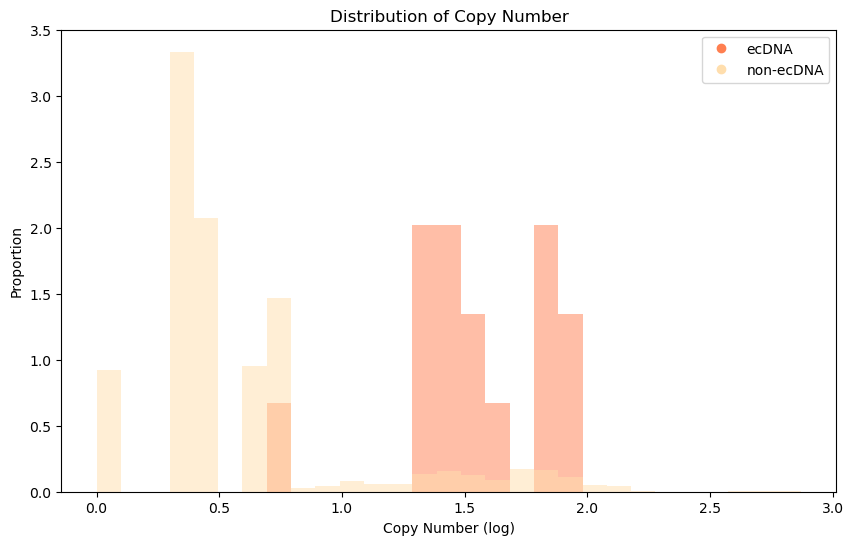

In [19]:
if use_facets_amp :
    
    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == True]['tcn']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == False]['tcn']
    log_non_ecDNA = [math.log10(x) if x > 0 else 0 for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color=colors[2], label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color=colors[1], label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Copy Number')
    plt.xlabel('Copy Number (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = [colors[2], colors[1]]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

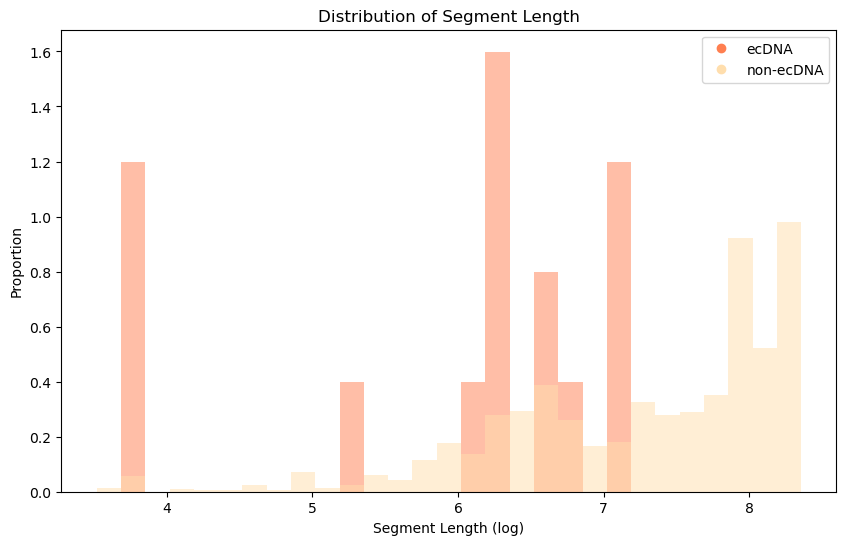

In [20]:
if use_facets_amp :
    
    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == True]['seg_length']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == False]['seg_length']
    log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color=colors[2], label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color=colors[1], label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Segment Length')
    plt.xlabel('Segment Length (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = [colors[2], colors[1]]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')


### Timeline

In [21]:
## Set up the data from CDSI ##

timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_follow_up.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen_surgery.txt', sep = '\t')

sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

# Dictionaries for time of last contact and death
last_contact_dict = {}
death_dict = {}
for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

# To store all the info
timelines = {}

# To keep track of start point
earliest_date = {}
for i, row in echo_ctype.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['tumorSampleId'] in sequencing_dict :
            if not row['patientId'] in timelines :
                timelines[row['patientId']] = []
                earliest_date[row['patientId']] = sequencing_dict[row['tumorSampleId']]
            else :
                earliest_date[row['patientId']] = min(earliest_date[row['patientId']], sequencing_dict[row['tumorSampleId']])

# Dictionary matching sampleId to ecDNA status
sample_to_ecDNA = {}
for i, row in echo_ctype.iterrows() :
    if row['patientId'] in timelines :
        if row['tumorSampleId'] in sequencing_dict :
            if sequencing_dict[row['tumorSampleId']] != earliest_date[row['patientId']] :
                if row['gene'] == geneToStudy and row['ecDNA_status'] == 'ecDNA' :
                    sample_to_ecDNA[row['tumorSampleId']] = 'ecDNA & Called'
                elif row['gene'] == geneToStudy :
                    sample_to_ecDNA[row['tumorSampleId']] = 'non-ecDNA & Called'
                elif not row['tumorSampleId'] in sample_to_ecDNA :
                    sample_to_ecDNA[row['tumorSampleId']] = 'Not Called'
                    

In [22]:
## Add other timepoints ##

for sample in sample_to_ecDNA :
    patientId = sample.split('-')[0] + '-' + sample.split('-')[1]
    try :
        timelines[patientId].append((sequencing_dict[sample] - earliest_date[patientId], sample_to_ecDNA[sample]))
    except :
        _ = 5
timelines_interesting = {key: value for key, value in timelines.items() if value}

endpoints = []
for patientId in timelines_interesting :
    if patientId in death_dict :
        timelines[patientId].append((death_dict[patientId] - earliest_date[patientId], "Patient Deceased"))
        endpoints.append(death_dict[patientId] - earliest_date[patientId])
    elif patientId in last_contact_dict :
        timelines[patientId].append((last_contact_dict[patientId] - earliest_date[patientId], "Last Contact"))
        endpoints.append(last_contact_dict[patientId] - earliest_date[patientId])
    # Not found, skipping patient
    else :
        timelines[patientId] = []

timelines_interesting = {key: value for key, value in timelines.items() if value}
        

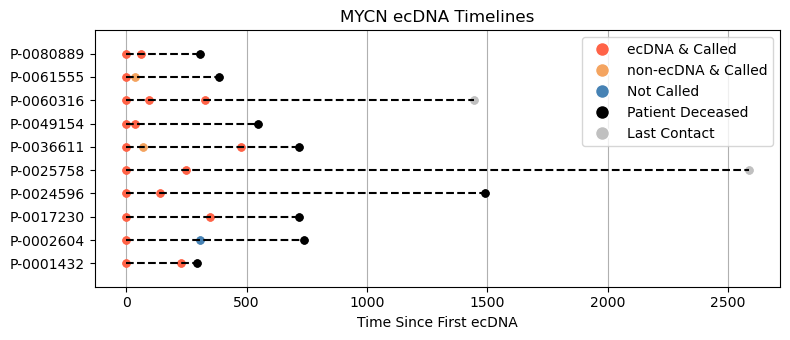

In [23]:
## Plot timeline ##

for i in timelines_interesting :
    timelines_interesting[i].insert(0, (0, 'ecDNA & Called'))

startpoints = []
for patientId in timelines_interesting :
    earliest = 10000000
    for pair in timelines_interesting[patientId] :
        earliest = min(earliest, pair[0])
    startpoints.append(earliest)
    
# Plotting the timelines
plt.figure(figsize=(8, 2 + 0.15 * (len(timelines_interesting))))  # Adjust figsize as needed

label_colors = {
    'ecDNA & Called': 'tomato',
    'non-ecDNA & Called': 'sandybrown',
    'Not Called': 'steelblue',
    'Patient Deceased': 'black',
    'Last Contact': 'silver',
}

for idx, (label, points) in enumerate(timelines_interesting.items(), start=1):
    # Extract x values (times) and labels
    times, labels = zip(*points)
    
    # Plot lines connecting points with label-specific color
    for i in range(len(times)):
            plt.plot([times[i], times[i]], [idx, idx], '.-', color=label_colors[labels[i]], markersize=10,linewidth=2)
    plt.hlines(y=idx, xmin=startpoints[idx-1], xmax=endpoints[idx-1], color='black', linestyle='--')

# Customize plot appearance
plt.ylim(0, len(timelines_interesting) + 1)  # Set y-axis limit to accommodate all timelines
plt.xlabel('Time Since First ecDNA')
plt.yticks(np.arange(1, len(timelines_interesting) + 1), timelines_interesting.keys())
plt.title(f'{geneToStudy} ecDNA Timelines')

# Add legend with colored markers
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in label_colors.items()]
plt.legend(handles=legend_handles, loc='upper right')

plt.grid(axis='x')
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
import os

os.system(f'jupyter nbconvert --to html --no-input --output html_outputs/ecs_case_study_{paths['projectName']}.html ecs_treatment.ipynb')